## Configurations

In [7]:
# import tensorflow as tf
import os
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
import scipy.stats as st
import pykrige

In [4]:
# Name of image to upscale.
image_name = "p_1024.png"
dim = 1024


## Deep Image Prior

In [3]:
# Functions
def load_image(filename, dim):
    with open(image_name, 'rb') as f:
        raw_image = tf.image.decode_png(f.read())

    converted = tf.image.convert_image_dtype(
        raw_image,
        tf.float32,
        saturate=True
    )
    
    resized = tf.image.resize_images(
        images = converted,
        size = [dim, dim]
    )

    resized.set_shape((dim,dim,3))

    blur = gblur(tf.expand_dims(resized, 0))

    return blur

def save_image(filename, image):
    converted_img = tf.image.convert_image_dtype(
        image,
        tf.uint8,
        saturate=True)

    encoded_img = tf.image.encode_png(converted_img)
    
    with open(filename, 'wb') as f:
        f.write(encoded_img.eval())

def down_layer(layer):
    layer = tf.contrib.layers.conv2d(
        inputs=layer,
        num_outputs=128,
        kernel_size=3,
        stride=2,
        padding='SAME',
        activation_fn=None)
    
    layer = tf.contrib.layers.batch_norm(
        inputs=layer,
        activation_fn=tf.nn.leaky_relu)

    layer = tf.contrib.layers.conv2d(
        inputs=layer,
        num_outputs=128,
        kernel_size=3,
        stride=1,
        padding='SAME',
        activation_fn=None)
    
    layer = tf.contrib.layers.batch_norm(
        inputs=layer,
        activation_fn=tf.nn.leaky_relu)
    
    return layer

def up_layer(layer):
    layer = tf.contrib.layers.batch_norm(
        inputs=layer)
    
    layer = tf.contrib.layers.conv2d(
        inputs=layer,
        num_outputs=128,
        kernel_size=3,
        padding='SAME',
        activation_fn=None)
    
    layer = tf.contrib.layers.batch_norm(
        inputs=layer,
        activation_fn=tf.nn.leaky_relu
    )
    
    layer = tf.contrib.layers.conv2d(
        inputs=layer,
        num_outputs=3,
        kernel_size=1,
        padding='SAME',
        activation_fn=None)
    
    layer = tf.contrib.layers.batch_norm(
        inputs=layer,
        activation_fn=tf.nn.leaky_relu)
    
    height, width = layer.get_shape()[1:3]
    layer = tf.image.resize_images(
        images = layer,
        size = [height*2, width*2]
    )
    
    return layer

def skip(layer):
    conv_out = tf.contrib.layers.conv2d(
        inputs=layer,
        num_outputs=4,
        kernel_size=1,
        stride=1,
        padding='SAME',
        normalizer_fn = tf.contrib.layers.batch_norm,
        activation_fn=tf.nn.leaky_relu)

    return conv_out

# Code from https://stackoverflow.com/a/29731818
def gkern(kernlen=5, nsig=3):
    """Returns a 2D Gaussian kernel array."""

    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return (tf.convert_to_tensor(kernel, dtype=tf.float32))

# Apply the gaussian kernel to each channel to give the image a
# gaussian blur.
def gblur(layer):
    gaus_filter = tf.expand_dims(tf.stack([gkern(),gkern(),gkern()], axis=2), axis=3)
    return tf.nn.depthwise_conv2d(layer, gaus_filter, strides=[1,1,1,1], padding='SAME')


In [3]:
# The number of down sampling and up sampling layers.
# These should be equal if the ouput and input images
# are to be equal.
down_layer_count = 5
up_layer_count = 5

image = load_image(image_name, dim)

rand = tf.placeholder(shape=(1,dim,dim,32), dtype=tf.float32)

# TODO: test if 32 channels improves performance
out = tf.constant(np.random.uniform(0, 0.1, size=(1,dim,dim,32)), dtype=tf.float32) + rand

# Connect up all the downsampling layers.
skips = []
for i in range(down_layer_count):
    out = down_layer(out)
    # Keep a list of the skip layers, so they can be connected
    # to the upsampling layers.
    skips.append(skip(out))

print("Shape after downsample: " + str(out.get_shape()))

# Connect up the upsampling layers, from smallest to largest.
skips.reverse()
for i in range(up_layer_count):
    if i == 0:
        # As specified in the paper, the first upsampling layers is connected to
        # the last downsampling layer through a skip layer.
        out = up_layer(skip(out))
    else:
        # The output of the rest of the skip layers is concatenated onto
        # the input of each upsampling layer.
        # Note: It's not clear from the paper if concat is the right operator
        # but nothing else makes sense for the shape of the tensors.
        out = up_layer(tf.concat([out, skips[i]], axis=3))
        
print("Shape after upsample: " + str(out.get_shape()))

# Restore original image dimensions and channels
out = tf.contrib.layers.conv2d(
    inputs=out,
    num_outputs=3,
    kernel_size=1,
    stride=1,
    padding='SAME',
    activation_fn=tf.nn.sigmoid)
print("Output shape: " + str(out.get_shape()))

E = tf.losses.mean_squared_error(image, gblur(out))




For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Shape after downsample: (1, 32, 32, 128)
Shape after upsample: (1, 1024, 1024, 3)
Output shape: (1, 1024, 1024, 3)
Instructions for updating:
Use tf.cast instead.


In [14]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(E)

sess = tf.InteractiveSession()
# sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

save_image("output/corrupt.png", tf.reshape(image, (dim,dim,3)))


C:\Users\jzw0n\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
for i in range(4001):
    # generate noise to learn the image 
    new_rand = np.random.uniform(0, 1.0/30.0, size=(1,dim,dim,32))
    _, lossval = sess.run(
        [train_op, E],
        feed_dict = {rand: new_rand}
    )
    if i % 100 == 0:
        image_out = sess.run(out, feed_dict={rand: new_rand}).reshape(dim,dim,3)
        save_image("output/%d_%s" % (i, image_name), image_out)
    # tmp_E = tf.losses.mean_squared_error(image, gblur(image_out))
    print(i, lossval)

0 0.062213805
1 0.06306828
2 0.05532633
3 0.052114535
4 0.04965094
5 0.04752429
6 0.0455149
7 0.043586913
8 0.041747
9 0.039974142
10 0.038252525
11 0.036609795
12 0.035039622
13 0.03350573
14 0.032038577
15 0.030592503
16 0.029201003
17 0.027843602
18 0.026480563
19 0.025171846
20 0.023877548
21 0.022618607
22 0.021416314
23 0.020248797
24 0.019145017
25 0.018097866
26 0.01709207
27 0.01612133
28 0.01518657
29 0.014298611
30 0.013438412
31 0.0126008885
32 0.0118172765
33 0.01105652
34 0.0103618605
35 0.009684843
36 0.009024128
37 0.008432859
38 0.007853185
39 0.007313764
40 0.006799038
41 0.006312374
42 0.0058660824
43 0.0054484536
44 0.0050557554
45 0.004680916
46 0.0043452266
47 0.004055414
48 0.0037935723
49 0.0035267973
50 0.0032440338
51 0.0030310052
52 0.0028109003
53 0.002616557
54 0.0024640542
55 0.0022826188
56 0.0021780003
57 0.0020144666
58 0.001924842
59 0.0018190831
60 0.0017273572
61 0.0016631815
62 0.0015706797
63 0.0015037619
64 0.0014478355
65 0.0013962669
66 0.001352

## Kriging Regression

In [31]:
img_f = imread(image_name).astype(float) / 255
img_c = imread('output/corrupt.png').astype(float) / 255
img_f_dip = imread('output/1300_p_1024.png').astype(float) / 255

(-0.5, 1023.5, 1023.5, -0.5)

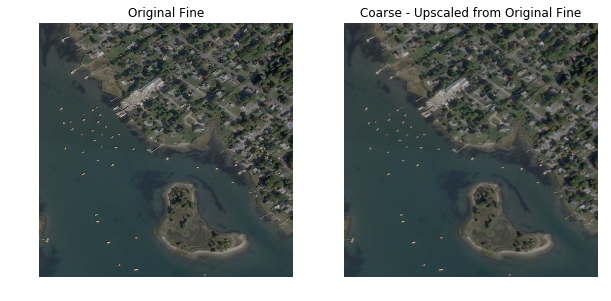

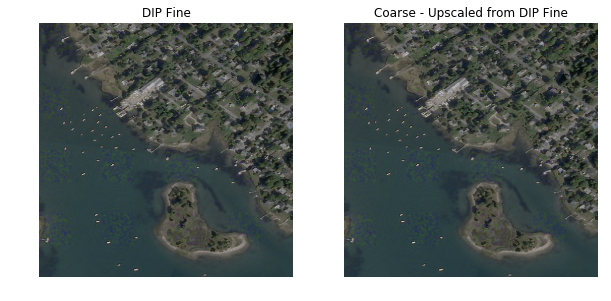

In [32]:
# display 
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(img_f)
axes[0].set_title('Original Fine')
axes[0].axis('off')

axes[1].imshow(img_c)
axes[1].set_title('Coarse - Upscaled from Original Fine')
axes[1].axis('off')

# display 
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(img_f_dip)
axes[0].set_title('DIP Fine')
axes[0].axis('off')

axes[1].imshow(img_f_dip)
axes[1].set_title('Coarse - Upscaled from DIP Fine')
axes[1].axis('off')

In [137]:
# residuals 
resi = img_f - img_c
resi_size = np.shape(resi)

# reshape
y = resi.reshape(resi_size[0]*resi_size[1], resi_size[2], order='C')


In [138]:
# generate locations [row, col]
loc1 = np.array(range(resi_size[0]))
loc2 = np.array(range(resi_size[1]))
loc1_rep = np.matlib.repeat(loc1, resi_size[1])
loc2_rep = np.array([loc2] * resi_size[0])
loc2_rep = np.concatenate(loc2_rep, axis=0)

loc = np.stack((loc1_rep, loc2_rep)).T

In [ ]:
from pykrige.uk import UniversalKriging

UK = UniversalKriging(loc[:,0], loc[:,1], y[:,0], variogram_model='linear',
                     drift_terms=['regional_linear'])


In [133]:
z, ss = UK.execute('grid', loc[:,0], loc[:,1])

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [57]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing

from pykrige.rk import RegressionKriging
from pykrige.compat import train_test_split

housing = fetch_california_housing()

In [52]:
p = housing['data'][:5000, :-2]
x = housing['data'][:5000, -2:]
target = housing['target'][:5000]

In [53]:
p_train, p_test, x_train, x_test, target_train, target_test \
    = train_test_split(p, x, target, test_size=0.3, random_state=42)


In [131]:
target_train

array([2.632, 0.69 , 1.382, ..., 0.685, 3.65 , 2.835])

In [58]:
svr_model = SVR(C=0.1)
rf_model = RandomForestRegressor(n_estimators=100)
lr_model = LinearRegression(normalize=True, copy_X=True, fit_intercept=False)

models = [svr_model, rf_model, lr_model]

for m in models:
    print('=' * 40)
    print('regression model:', m.__class__.__name__)
    m_rk = RegressionKriging(regression_model=m, n_closest_points=10)
    m_rk.fit(p_train, x_train, target_train)
    print('Regression Score: ', m_rk.regression_model.score(p_test, target_test))
    print('RK score: ', m_rk.score(p_test, x_test, target_test))


regression model: SVR
Finished learning regression model
Finished kriging residuals
Regression Score:  -0.03405385545698292
RK score:  0.6619557666501965
regression model: RandomForestRegressor
Finished learning regression model
Finished kriging residuals
Regression Score:  0.6966578717152786
RK score:  0.7420371101401683
regression model: LinearRegression
Finished learning regression model
Finished kriging residuals
Regression Score:  0.5277968398381672
RK score:  0.6049089336167253
